In [1]:
!pip uninstall -y tensorflow
!pip install tensorflow --upgrade

Found existing installation: tensorflow 2.17.1
Uninstalling tensorflow-2.17.1:
  Successfully uninstalled tensorflow-2.17.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 103.5 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import imdb
from keras import layers
import matplotlib.pyplot as plt
import numpy as np

In [3]:
vocab_size = 20000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)

maxlen = 200
#Pad sequences:
print('Pad sequences (samples x time)')
input_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
input_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Pad sequences (samples x time)
input_train shape: (25000, 200)
input_test shape: (25000, 200)


In [4]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [5]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [6]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed-forward network inside the transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x, training=False)
x = layers.GlobalAveragePooling1D()(x) #add global average pooling
x = layers.Dropout(0.5)(x) #add dropout
x = layers.Dense(20)(x) #add dense layer with about 20 neurons
x = layers.Dropout(0.5)(x) #add dropout
outputs = layers.Dense(2, activation='softmax')(x) #add the final dense layer for classification

model = keras.Model(inputs=inputs, outputs=outputs)

In [7]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [8]:
history = model.fit(
    input_train, y_train, batch_size=32, epochs=15, validation_data=(input_test, y_test)
)

Epoch 1/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.6604 - loss: 0.6088 - val_accuracy: 0.8736 - val_loss: 0.2927
Epoch 2/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9196 - loss: 0.2263 - val_accuracy: 0.8591 - val_loss: 0.3669
Epoch 3/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9525 - loss: 0.1416 - val_accuracy: 0.8396 - val_loss: 0.4613
Epoch 4/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9736 - loss: 0.0870 - val_accuracy: 0.8542 - val_loss: 0.4756
Epoch 5/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9852 - loss: 0.0524 - val_accuracy: 0.8456 - val_loss: 0.6437
Epoch 6/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9888 - loss: 0.0394 - val_accuracy: 0.8468 - val_loss: 0.7719
Epoch 7/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9910 - loss: 0.0307 - val_accuracy: 0.8364 - val_loss: 0.9558
Epoch 8/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9936 - loss: 0.0218 - val_accuracy:

In [9]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

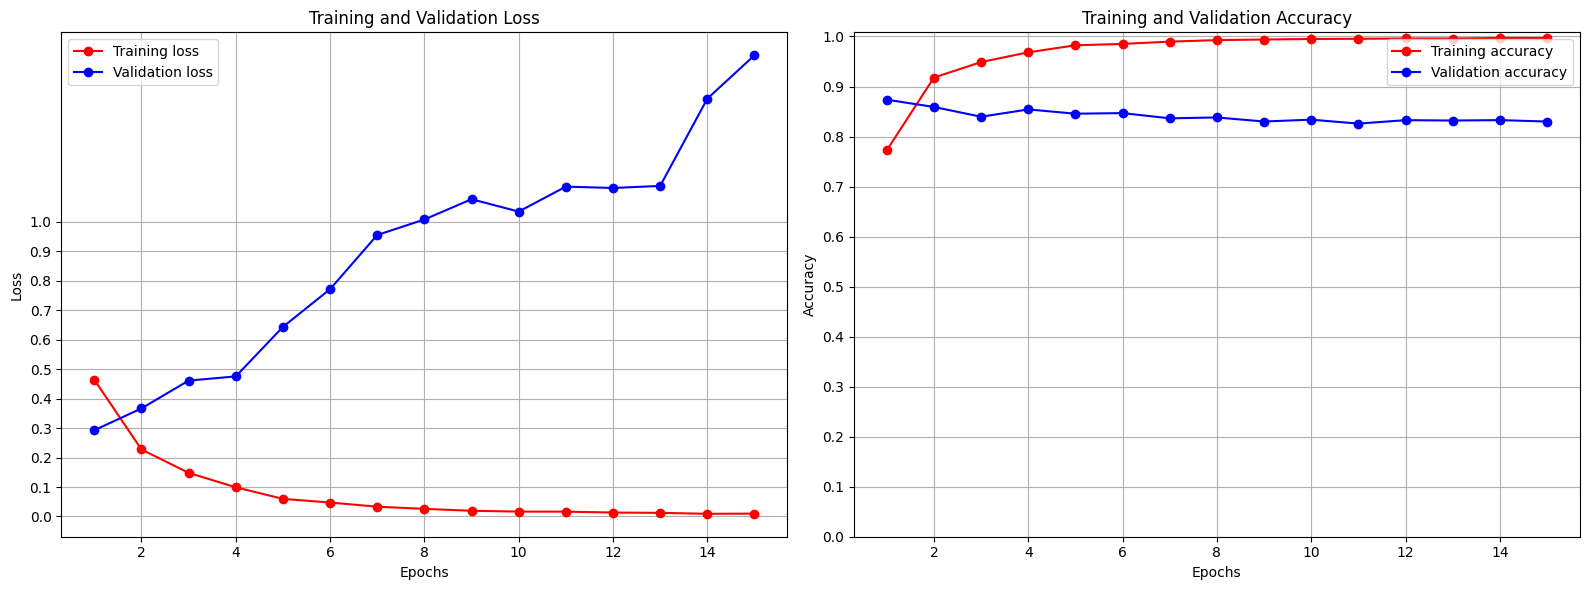

In [10]:
epochs = range(1, len(history_dict['accuracy']) + 1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(epochs, history_dict['loss'], 'r-o', label='Training loss')
ax1.plot(epochs, history_dict['val_loss'], 'b-o', label='Validation loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

loss_ticks = np.arange(0, 1.1, 0.1)
ax1.set_yticks(loss_ticks)

ax2.plot(epochs, history_dict['accuracy'], 'r-o', label='Training accuracy')
ax2.plot(epochs, history_dict['val_accuracy'], 'b-o', label='Validation accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid(True)
ax2.legend()

accuracy_ticks = np.arange(0, 1.1, 0.1)
ax2.set_yticks(accuracy_ticks)

plt.tight_layout()
plt.show()

In [11]:
!pip install --upgrade tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.9 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.0
    Uninstalling wrapt-1.17.0:
      Successfully uninstalled wrapt-1.17.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorboard
    Found existing installation

In [1]:
!pip install --quiet vit-keras
!pip install --quiet tensorflow-addons

from vit_keras import vit
import tensorflow_addons as tfa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 11.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


1/1 [==============================] - 3s 3s/step
Prediction: Eskimo dog, husky


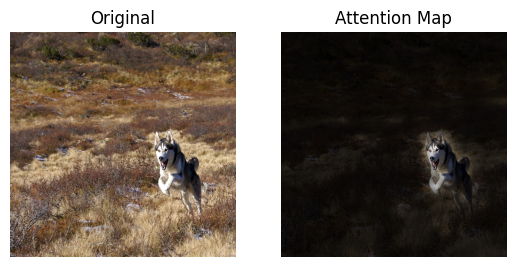

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from vit_keras import vit, utils, visualize

# Load a model
image_size = 384
classes = utils.get_imagenet_classes()
model = vit.vit_b16(
    image_size=image_size,
    activation='softmax',
    pretrained=True,
    include_top=True,
    pretrained_top=True
)
classes = utils.get_imagenet_classes()

# Get an image and compute the attention map
url = 'https://upload.wikimedia.org/wikipedia/commons/b/bc/Free%21_%283987584939%29.jpg'
image = utils.read(url, image_size)
attention_map = visualize.attention_map(model=model, image=image)
print('Prediction:', classes[
    model.predict(vit.preprocess_inputs(image)[np.newaxis])[0].argmax()]
)  # Prediction: Eskimo dog, husky

# Plot results
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(image)
_ = ax2.imshow(attention_map)

In [5]:
import tensorflow_datasets as tfds
import os
import shutil
import tensorflow as tf

# Download the CIFAR-10 dataset
data, info = tfds.load('cifar10', with_info=True, as_supervised=True)
train_data, test_data = data['train'], data['test']

# Define paths for train and validation directories
base_dir = '/content/data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')

# Create the directory structure
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Create subdirectories for each class in the training and validation directories
class_names = info.features['label'].names  # List of class names in CIFAR-10
for class_name in class_names:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.FOQF6W_3.0.2/cifar10-train.tfrecord*...:   0%|         …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.FOQF6W_3.0.2/cifar10-test.tfrecord*...:   0%|          …

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [6]:
import numpy as np
import tensorflow as tf

# Function to save images to a folder based on their class
def save_image(image, label, split='train'):
    class_name = class_names[label.numpy()]
    folder_path = os.path.join(train_dir if split == 'train' else val_dir, class_name)

    # Convert the image to uint8 (as images are in float32 in TensorFlow)
    image = tf.image.convert_image_dtype(image, dtype=tf.uint8)

    # Save the image
    filename = os.path.join(folder_path, f"{np.random.randint(100000)}.png")
    tf.io.write_file(filename, tf.image.encode_png(image))

# Split and save data
train_size = int(0.8 * len(train_data))  # 80% for training
val_size = len(train_data) - train_size  # 20% for validation

# Convert dataset to numpy format and split
train_data = list(train_data)
np.random.shuffle(train_data)

# Saving images for train and validation sets
for image, label in train_data[:train_size]:
    save_image(image, label, split='train')

for image, label in train_data[train_size:]:
    save_image(image, label, split='validation')


In [7]:
# Load and preprocess image function
def load_and_preprocess_image(image, label, image_size=224):

    image = tf.image.resize(image, (image_size, image_size))  # Resize image
    image = image / 255.0  # Normalize pixel values to [0, 1]

    # Data augmentation (can be expanded)
    # Apply augmentations on batches
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_crop(image, size=[tf.shape(image)[0], image_size, image_size, 3])

    return image, label

# Create dataset function
def create_dataset(data_dir, image_size=224, batch_size=32):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        image_size=(image_size, image_size),
        batch_size=batch_size,
        label_mode='int',   # For integer labels
        shuffle=True
    )
    dataset = dataset.map(lambda x,y: load_and_preprocess_image(x, y, image_size)) # Apply data augmentation using load_and_preprocess_image function
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)  # For better performance
    return dataset

# Create train and validation datasets
train_dataset = create_dataset(train_dir, image_size=224, batch_size=32)
val_dataset = create_dataset(val_dir, image_size=224, batch_size=32)


Found 39168 files belonging to 10 classes.
Found 9950 files belonging to 10 classes.


In [9]:
from vit_keras import vit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, GlobalAveragePooling1D, Dropout
from tensorflow.keras.optimizers import Adam

# Load Vision Transformer model (without top layers)
vit_model = vit.vit_b32(
    image_size=224,
    activation='softmax',
    pretrained=True,
    include_top=False,
    pretrained_top=False
)

use_global_pooling = False # change to True to use global average pooling

# Build the custom model
if use_global_pooling:
    model = Sequential([
        vit_model,
        GlobalAveragePooling1D(), #use GlobalAveragePooling1D instead of GlobalAveragePooling2D
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(len(class_names), activation='softmax')  # Output layer with classes as per CIFAR-10
    ])
else:
    model = Sequential([
        vit_model,
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(len(class_names), activation='softmax')  # Output layer with classes as per CIFAR-10
    ])


# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_dataset,
    epochs=10,
    batch_size=32,
    validation_data=val_dataset
)


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Epoch 1/10
1224/1224 [==============================] - 532s 403ms/step - loss: 0.4650 - accuracy: 0.8485 - val_loss: 0.2956 - val_accuracy: 0.9037
Epoch 2/10
1224/1224 [==============================] - 532s 434ms/step - loss: 0.2291 - accuracy: 0.9266 - val_loss: 0.2237 - val_accuracy: 0.9285
Epoch 3/10
1224/1224 [==============================] - 532s 435ms/step - loss: 0.1747 - accuracy: 0.9429 - val_loss: 0.2054 - val_accuracy: 0.9384
Epoch 4/10
1224/1224 [==============================] - 491s 401ms/step - loss: 0.1380 - accuracy: 0.9545 - val_loss: 0.2114 - val_accuracy: 0.9350
Epoch 5/10
1224/1224 [==============================] - 492s 401ms/step - loss: 0.1201 - accuracy: 0.9600 - val_loss: 0.1961 - val_accuracy: 0.9418
Epoch 6/10
1224/1224 [==============================] - 491s 401ms/step - loss: 0.0996 - accuracy: 0.9670 - val_loss: 0.2177 - val_accuracy: 0.9447
Epoch 7/10
1224/1224 [==============================] - 532s 435ms/step - loss: 0.0882 - accuracy: 0.9711 - val_

In [11]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

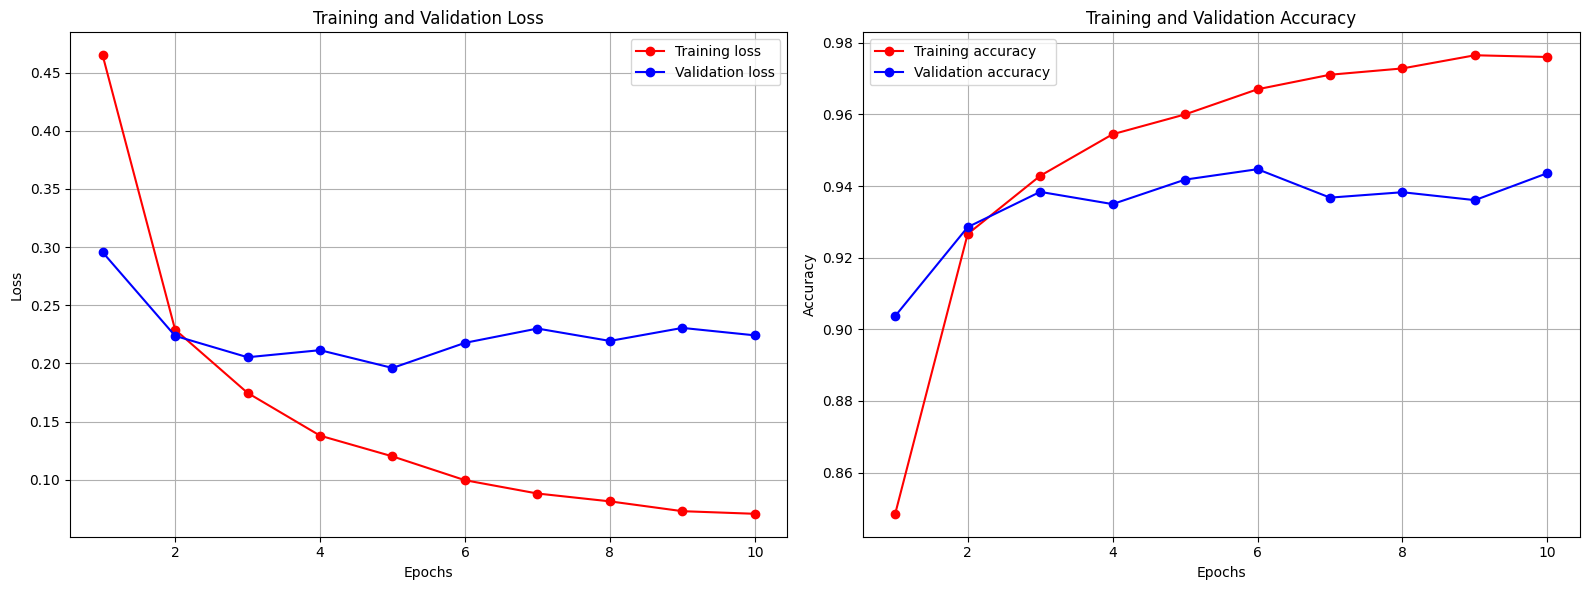

In [14]:
import matplotlib.pyplot as plt

epochs = range(1, len(history_dict['accuracy']) + 1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(epochs, history_dict['loss'], 'r-o', label='Training loss')
ax1.plot(epochs, history_dict['val_loss'], 'b-o', label='Validation loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

# loss_ticks = np.arange(0, 1.1, 0.1)
# ax1.set_yticks(loss_ticks)

ax2.plot(epochs, history_dict['accuracy'], 'r-o', label='Training accuracy')
ax2.plot(epochs, history_dict['val_accuracy'], 'b-o', label='Validation accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid(True)
ax2.legend()

# accuracy_ticks = np.arange(0, 1.1, 0.1)
# ax2.set_yticks(accuracy_ticks)

plt.tight_layout()
plt.show()